<a href="https://colab.research.google.com/github/SeanOnamade/BasicProjects/blob/main/02_1_Representations_and_Tensor_Paradigm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation and AI


The history of Artificial Intelligence is often told through the lens of models, milestones, and eye-catching applications.

In this course, we take a unique and opinionated approach -- focusing on the concept of **representation**, and trace its evolution through the history of AI.

By **representation**, we mean how human knowledge and experiences are encoded within the computational systems. This unique _representation_ angle reveals the philosophical struggles, breakthroughs, and ongoing dilemmas that shape what AI can and cannot do.

Let's dive in!

**Table of Contents:**
1. [The Symbolic Era: Symbols and Logics](#symbolic_era)
2. [The Probabilistic Patch: Uncertainty Enters the Picture](#probabilistic_patch)
3. [The Rise of Neural Networks: Learning to Represent](#rise_of_neural_nets)
4. [Distributed Representation](#distributed_representation)
6. [Conclusion](#conclusion)

## <a name="symbolic_era">1. The Symbolic Era: Symbols and Logics

Early AI pioneers believed the secrets of intelligence lay in our ability to *manipulate symbols* and *reasoning using logical rules*.

How did they arrive at this belief?

There is a path dependency here. Early AI practitioners were mathematicians, and it is natural for a mathematician to model the world using the language they are most familiar with. As a result, AI systems during this era relied on handcrafted knowledge bases and rules.

### Toy knowledge base

The following program shows a toy knowledge base. By adding simple facts such as `(John, father-of, Tom)` and logic rules such as `IF (A father-of B) AND (B father-of C), THEN A grandfather-of C`, we have an AI that can perform logical reasoning.

In [ ]:
from dataclasses import dataclass

@dataclass
class Triple:
    """ subject, predicate, object relationship. tom is-father-of kate """
    a: str
    r: str
    b: str

class KnowledgeBase:
    def __init__(self):
        self.data: list[Triple] = []
        self.entities: set[str] = set()
        self.rules = {}

    def add_fact(self, t: Triple):
        self.data.append(t)
        self.entities.update([t.a, t.b])

    def check(self, a, r, b):
        """ Check each triple for fact support """
        for t in self.data:
            if t.a == a and t.b == b and t.r ==r:
                return True
        if r in self.rules:
            return self.rules[r](a, b)
        return False

    def init_rules(self):
        """ Logical rules for the knowledge base """
        self.rules['is-grandfather'] = lambda a, b: any(
            self.check(a, 'is-father', x) and self.check(x, 'is-father', b) for x in self.entities
        )
        # add more logic rules here.

kb = KnowledgeBase()
kb.init_rules()

kb.add_fact(Triple("john", "is-father", "tom"))
kb.add_fact(Triple("sandy", "is-mother", "tom"))
kb.add_fact(Triple("ben", "is-father", "john"))

print(kb.check('ben', 'is-grandfather', 'tom'))
print(kb.check('jerry', 'is-grandfather', 'tom'))

True
False


##### ⚒️ **Homework** ⚒️

Try to add a new rule (to the `init_rules` function), stating that if `A` and `B` have the same parents, they are siblings.

The hidden cell below has the answer:

In [ ]:
### answer
def rule_init(self):
  self.rules['sibling'] = lambda a, b: any(
      self.check(x, 'is-father', a) and self.check(x, 'is-father', b) for x in self.entities
    ) or any (
      self.check(x, 'is-mother', a) and self.check(x, 'is-mother', b) for x in self.entities
    )

### Limitations of symbolic reasoning

Early AI practitioners believed that artificial general intelligence (AGI) could be achieved via symbolic systems:

>  A physical symbol system has the necessary and sufficient means for general intelligent action. [\[1\]](https://dl.acm.org/doi/10.1145/360018.360022)
>
>  — Allen Newell and Herbert A. Simon

The belief was that if only there were a giant, highly-structured encyclopedia, filled with facts and relationships, then we'd be able to reason about anything!

Unfortunately, this turns out to be much easier said than done. Looking back, the belief that symbolic systems can lead to AGI and that mathematics is the ultimate form of intelligence were unintentionally arrogant and unfortunately ignorant.

These symbolic AI systems come with two main disadvantages:

- **Brittleness**: These systems *do not* handle the uncertainty or ambiguity prevalent in the real world. For example, the statement `IF A and B are mother and father of X, then A and B are married` is often true, but not always. Logical representation does not capture the "plausible" nature of human reasoning.

- **Knowledge Acquisition Bottleneck**: Manually creating and maintaining the complex knowledge bases was time-consuming and laborious.

### Symbolic Paradigm Today

Despite this paradigm's limitations, it remains alive and well in today's world. Here are some astonishing successes of the symbolic era:

* In the 1950s, a theorem prover that could solve all homework problems from a high-school geometry textbook.
* Claude Shannon envisioned computer playing chess in 1949, and finally Deep Blue defeated world champion Garry Kasparov in 1997.
* The [wikidata project](https://www.wikidata.org/wiki/Wikidata:Introduction) is the largest open knowledge base, containing ~17.8 billion triples of knowledge.

## <a name="probabilistic_patch"> 2. The Probabilistic Patch: Uncertainty Enters the Picture

Symbolic AI has a severe limitation: it cannot handle uncertainty, and uncertainty is life.

Enter the **probabilistic revolution**. Instead of rigid rules, these systems can reason with probabilities, allowing for a degree of flexibility and nuance. Models such as bayesian networks and logistic regression were developed to directly encode these types of probabilistic relationships.

But if our rules are probabilistic, an immediate problem arises: how do we decide the probabilities?  This is where **learning** starts to shine -- the idea that we can learn from data.

To illustrate how "plausible" rules can be learned, we devise an easy to understand toy problem below and then train a `LogisticRegression` model on the problem. The problem is: _given a binary number, determine if it is even or odd_.

Clearly if we used a rule based system, we could simply check ` x % 2 `, or really if the least significant bit is `0`. Here, we do not explicitly tell the computer this rule, and see if it can discover the rule through learning.

In [ ]:
import numpy as np

def convert_to_binary(number, num_digits=6):
    """ Output binary representation of number as a one-hot encoding for number up to N digits """
    binary_repr = np.binary_repr(number, width=num_digits)  # Convert to binary

    encoding = np.zeros((num_digits), dtype=int)
    for i, digit in enumerate(binary_repr):
        encoding[i] = int(digit)

    return encoding.flatten()

# We produce the training data of random numbers (0-63) and their labels.
np.random.seed(4222) # Random seed is fixed to ensure reproducibility.

def get_training_data(label_func):
    numbers = np.random.randint(0, 64, size=1000)

    # Hide a few numbers from the computer, so it cannot possibly just memorize.
    numbers = np.setdiff1d(numbers, np.array([12, 13, 14, 15]))

    X = np.array([convert_to_binary(num) for num in numbers])
    y = np.array([label_func(num) for num in numbers])  # Labels: 1/True if divisible by 2, else 0/False
    return numbers, X, y

numbers, X, y = get_training_data(lambda num: num % 2 == 0)
for i in range(5):
    print(f"Number: {numbers[i]}, Binary representation: {X[i]}, is_even: {y[i]}")

Number: 0, Binary representation: [0 0 0 0 0 0], is_even: True
Number: 1, Binary representation: [0 0 0 0 0 1], is_even: False
Number: 2, Binary representation: [0 0 0 0 1 0], is_even: True
Number: 3, Binary representation: [0 0 0 0 1 1], is_even: False
Number: 4, Binary representation: [0 0 0 1 0 0], is_even: True


Now we have the training dataset, and it looks correct. We will go ahead and train the model.

In [ ]:
from sklearn.linear_model import LogisticRegression

def train(X, y, max_iter=10):
    return LogisticRegression(max_iter=max_iter).fit(X, y)

def predict(clf, n):
    return clf.predict(convert_to_binary(n).reshape(1, -1))[0]

model = train(X, y)
for i in [12, 13, 14, 15]:
    print(f"Number: {i}, (Model prediction) is_even: {predict(model, i)}")

Number: 12, (Model prediction) is_even: True
Number: 13, (Model prediction) is_even: False
Number: 14, (Model prediction) is_even: True
Number: 15, (Model prediction) is_even: False


As we can see, the results are correct: our classifier maps `12` and `14` to true values (they are even) while the odd numbers are mapped to false.

### How is the rule represented?

Judging from the generalization behavior on unseen numbers, we can conclude that the model has learned **something** about this problem, but what?

#### An aside on logistic regression

First, it's worth taking a moment to consider how logistic regression works. Logistic regression is a statistical method used to predict a binary outcome based on one or more predictor variables. In simple terms, it's a model that learns to predict the outcome of a yes/no question by considering various factors.

Take the example of predicting whether a person has the flu based on their symptoms. The logistic regression model will learn to predict whether a person has the flu (outcome) based on the person's symptoms (predictive factors), e.g. presence of a fever, cough, sore throat, etc. The outcome is binary - the person either has the flu (yes) or doesn't have the flu (no).

In this case, logistic regression would analyze the relationship between these symptoms and past known cases of flu. For example, it might find that people with a fever, cough, and sore throat are more likely to have the flu. Then, when a new person comes in with a certain set of symptoms, the logistic regression model uses this relationship to predict the probability that this person has the flu. For instance, if a person has a fever, cough, and sore throat, the model might predict they have a 75% chance of having the flu.

#### Opening up the model
Given this context, let's return to our toy problem of predicting whether a number is even or odd. To understand what our model has learned, we will take a look at it's coefficients, or weights.

Remember, we trained our logistic regression model to predict whether a number is even (outcome) based on its the binary representation (predictive factors). The model has one weight per bit, let's graph these weights:

_Note: don't worry about the nuances of the code too much._

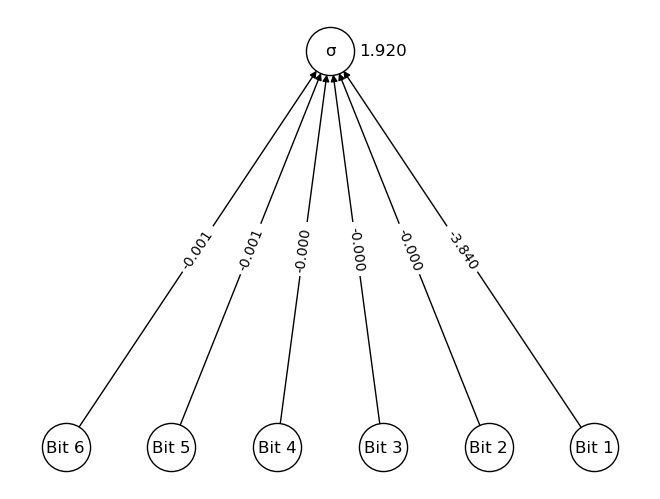

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_coff(model):
  # Create a graph
  G = nx.DiGraph()
  pos = {}

  for i in range(6):
    weight = f"{model.coef_[0][i]:.3f}"
    name = f"Bit {6-i}"
    G.add_edge(name, 'σ', weight=weight)
    pos[name]=(i * 2, 0)
  pos['σ'] = (5, 1)

  # Draw the linear classifier
  nx.draw(G, pos, with_labels=True, node_size=1200, node_color='white', edgecolors='black')
  # Draw edge labels
  edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

  # Draw the intercept value
  pos['σ'] = (6, 1)
  nx.draw_networkx_labels(G, pos, labels={'σ': f"{model.intercept_[0]:.3f}"})

  # Show the plot
  plt.axis('off')
  plt.show()

plot_coff(model)

Let's break down this diagram. The bottom row of nodes represents the 6 bits of input going into our model, the edges coming out of each node represent the weight the model has learned for that bit, and the top node ($σ$) represents the decision made by the model. To get the raw model score or "logits", we simply multiply the edge weight by the bit value for each bit, and then add the intercept value (`1.920`) next to $σ$. Therefore, a high magnitude weight (very high or very low) means that the bit is important to the final prediction.

Notice that every node has a weight value that is basically 0, except for bit 1, which represents the smallest and bit in our bit representation.

Aha! This means the rule is indeed discovered by the model. To make the rule explicit, refer to the below table.

| Last bit  | Model output (logits)| Model output (probability) | Classifier Value  |
| ----------- | ----------------- | ------------------ | ----------------- |
| 0           | 1.920             |          0.879          |  True         |
| 1           | -1.920            |         0.127           | False       |

Let's try a similar problem, _whether a number is evenly "divisible by 4"_, to acquire a deeper intuition of the model.

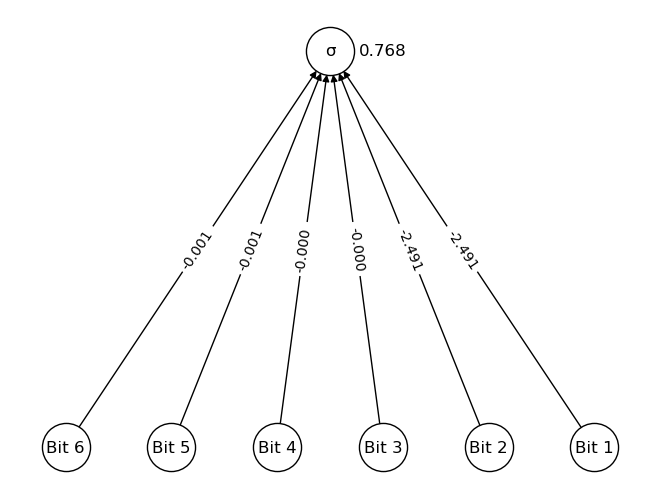

In [ ]:
numbers, X, y = get_training_data(lambda num: num % 4 == 0)
model = train(X, y)
plot_coff(model)

As expected, our model correctly learned that if a number is evenly divisible by `4`, both of its last two bits need to be `0`.

| Bit 2     | Bit 1  | Input to $\sigma$ (logits)| Output of $\sigma$ (p) | Classifier Value  |
| ----------- | -------- | ----------------- | ------------------ | ----------------- |
| 0       | 0    | 0.768             |         0.68          |  True         |
| 0       | 1   | -1.723             |          0.151          |  False         |
| 1       | 0    | -1.723           |          0.151          |  False         |
| 1       | 1   | -4.214       |         0.014         | False       |

We see again that a simple rule `BIT_2 == 0 && BIT_1 == 0` translated into a vector of multiple non-zero values.

⚒️ **Homework** ⚒️

Change the dataset label `y`. Try a few different labels. For example, try to see if the model can tell if a number is divisible by `N` (`N` can be 3, 4, 5 ...). What do you observe?

### What can the machine learn?

Though the example is toyish, we can draw three takeaways that are universally true in machine learning.

1. Machines **can** learn from data, without being explicitly told what pattern they should look for inside the data. No more `kb.init_rules`, data itself manifests the pattern and our learning process can extract the hidden pattern.

2. The learned model is as powerful as the logical rule, but represented differently. Here, the learned rule is represented as a vector (the coefficients and intercept value of the logistic classifier), not am `IF` statement.  This is a profound intuition that we want our readers to start groking: **rules can be represented as vectors**, and **reasoning can be represented as numeric operations on vectors**. We will come back to this profound intuition in the next section.

3. In this set up, data given to the model are preprocessed into **features**. In our toy example, we converted our number into a binary representation to get six features. To a machine learning model, features represent everything they know about the world. In other words, **features** serve as a conceptual bridge that links two subproblems of AI: how do we represent the world to a model (via feature engineering) and how do we fit the model to the world (via machine learning).

The probabilistic patch led to the thrive of ML as a way to propel AI forward. The question is, can we go further?

## <a name="rise_of_neural_nets"> 3. The Rise of Neural Networks: Learning to Represent

The advent of deep learning marked a significant turning point in AI representation: representations can now be learned.

In classic machine learning, to feed a model with data, we typically would hand-craft "features" as inputs. These features are effectively representations of the data. As we discussed above, though the model now is patched probabilistically, the features are still essentially symbolic -- for example they represent if a certain bit is 0 or 1, or if an edge is detected in a patch of image etc. Though the models can be trained with data, the features themselves are designed by hand.

The key shift in deep learning is that we do not need to hand-craft those representations -- they too can be learned. We have entered an era where raw data (images, text, voice) can be used as input to the neural network, and symmetrically, the network can output images, text and voice signals. This paradigm shift fueled remarkable progress in computer vision, natural language processing, and other domains of AI. All these can be traced back to a key insight discovered by Geoffrey Hinton in 1981.


## <a name="distributed_representation"> 4. Distributed Representation


In the "How is the rule represented" section earlier, we hinted that while a logic rule can be represented as an `IF` statement, it can also be represented as a vector. However, our observation is specific to the problem itself.


Geoffrey Hinton made a much generalized observation in 1981: he argues that many symbolic entities (facts, rules, words) are likely represented as a "pattern of activities distributed over many computing elements".  Translating the terminology of the era to simple English: entities can be represented as vectors (of multiple elements). Each element of the vector represents some partial information about the entity, and collectively it forms an "activation pattern" for the entity.  The representation is called **distributed** because it's no longer attached to a singular symbol -- the information is distributed among a bunch of numbers.


If the above language seems obscure to you, you are not alone: the concept of distributed representation is not intuitive. Let's visualize it in the human brain.

### Distributed Representation in Human Brain


In the 1990s, functional magnetic resonance imaging (fMRI) was invented to measure brain activity. It detects changes associated with blood flow. Since cerebral blood flow and neuronal activation are correlated, the heat image we see from fMRI indicates active brain activity in the region.


The following image, originally reported in "A Neurosemantic Theory of Concrete Noun Representation Based on the Underlying Brain Codes" [\[2\]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0008622), shows an fMRI image of a human brain activation when looking at the words "apartment" and "carrot".


<img src="resources/images/pone.0008622.g005.png" alt="brain-fmri" width="30%"/>

We can see that multiple brain regions are activated on one word, indicating a distributed representation of words in the human brain.

### Tensors as a Unified Representation Format

#### An introduction to tensors
Our world is multi-modal in nature -- we interact with text, images, videos, tables, graphs and code. Distributed representation provides a unified path for handling these inputs in a unified way: they can all be represented distributedly. In modern deep learning, we use a unified object called "tensor" to represent them. AI as a whole has embraced the tensor paradigm.


Mathematically, tensors are simply multi-dimensional arrays. While the term tensor can be thought of as solely a generalization of numbers (scalars), vectors (1D), matrices (2D) and higher dimensional matrices (kD), in modern AI, tensors are used as distributed representations. In the same way that a particular compression algorithm may choose to represent any digital object as well formatted binary, techniques in ML can be imagined to represent any digital object as a tensor of some dimensionality. Conforming to a tensor representation is not precisely a compression (there is no guarantee of losslessness, for example), but it can be a useful metaphor.

Tensors can represent many different types of information, such as:
1. Multimodal media - a word can be represented as a tensor, so too a sentence, an image, or even a batch of images (i.e. a video)
2. A neural network's input, intermediate values, and output (whether that's probabilities, the next word, or a generated image) are all tensors
3. The weights and gradients in a neural network

Aligning on tensor representations (e.g. encoding text as token tensors and images as RGB pixel tensors) across the field allows the same or similar architectures & optimizations to be applied across different tensor representations, and even different modalities. Understanding this representation interpretation can help us understand some designs in modern neural network architecture, and see how the underlying techniques can be seen repeatedly in solutions that may initially appear quite fundamentally different.

#### How neural networks use tensors
From a high level, we can split a modern neural network into three distinctive stages:

* Map multimodal signals to tensor representations
* Progressively process representations
* Map representations back to signals

Let's look at them one by one.


**Map Multimodal Signals to Tensor Representations**

From a high level, all deep learning networks operate in the **representation** space. To take in text or image as input, we would first transform the input into the representation space. For an image, we can simply use the RGB values for each pixel in the image, giving us a tensor with the shape 3 x height x width. For a language model, we can use tokens, which are pieces of text (e.g. words, word parts, or individual characters) that have been encoded into a distributed representation (also called embeddings) using a simple lookup table, giving us a 1D tensor with N values.

An illustration of an embedding table (using GPT-2 tokenizer).

| Id          |   Token      | Embedding    |
| ----------- | ----------- | ------------- |
| 15496      | Hello       |  [0.5190, 0.3122, 0.7978, 0.2028, ...] |
| 995   | _world        |   [0.6217, 0.5354, 0.0911, 0.9505, ... ]|
| 0     |   !           | [0.3560, 0.7853, 0.8489, 0.0324, ... ]|
| [GoldMagikarp](https://www.lesswrong.com/posts/jbi9kxhb4iCQyWG9Y/explaining-solidgoldmagikarp-by-looking-at-it-from-random)  | 42202 | [0.5744, 0.9258, 0.0247, 0.3403, ...]|


**Progressively Process the Representations**

After mapping signals to tensor representations, we can apply any tensor operations onto these representations. We often string together multiple layers of such operations, putting the "deep" in deep neural network. From the representation point of view, being deep has its purpose -- it allows the network to progressively process the representation, to derive higher level representations, or to refine the relationship between those representations.

A classic way to visualize different levels of representations is by visualizing a convolutional neural network (CNNs) that has been trained to identify animals in images. Specifically, we'll plot out how the CNN represent an inputted image of a cat at different levels of "deepness".
<img src="resources/images/cnn_conv_visualization.png" alt="cnn_conv_visualization" width="50%"/>

The top row is what the model "sees" after applying the first convolutional layer to the cat image. Notice that much of the raw pixel information is retained. The second row is what the model "sees" after applying the second convolutional layer to the outputs from the first layer; the information is now slightly more abstract. This continues until we reach the final row, where we are left with a very simple representation of the original cat image. You may look at the final row of images and wonder how the CNN could possibly know whether these images represent a cat, dog, or cassowary, but that's only because you don't share the representation of the cat that the CNN has learned.

Think about it. A black and white cartoon image of a cat has an _extremely_ different pixel representation from a photorealistic image of a cat, yet you can easily identify both as cats. How? Because your mental representation of a cat is greatly abstracted from the pixel representation - in other words, you aren't comparing pixels one-by-one to decide if an image is of a cat or not. The same is true for our CNN! Our model has taken a complex pixel representation and learned a much more simplified representation, one that is much more easily used for image classification.

You can explore more visualizations like the one above [here](https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/conv2d2_2.html).

**Map Representations Back to the Output**

Now that we have a representation of the inputted data, we want to map this representation to something useful, such as a label for image classification, or token probabilities if we are training a language model to generate text.

We will dive into more details later. For now it is sufficient to look at the last layer of deep learning neural networks, such as the `softmax` layer, as an interface that translates the representations (logits) to probabilities (values over all possible outputs and sums up to one). In places where we cannot assign probabilities (such as images and videos where they do not have discrete tokens to assign probabilities to), researchers invented architectures such as deconvolution (the inverse of convolution) in `U-Net` to restore pixels from internal representations.

<img src="resources/images/softmax.png" alt="softmax.png" width="50%"/>

### Tensor and Deep Learning Frameworks


Given deep neural networks are just collections of tensors and operations over those tensors, it is not a surprise that while modern deep learning frameworks such as PyTorch and Tensorflow have many bells and whistles, at their core, they are simply tensor libraries. In fact, these frameworks are considered **frontends** to highly optimized tensor operators on accelerators (GPU/TPU/ASIC chips).

An important aspect of the tensor paradigm that we are not covering here is that the learning process itself (back propagation and gradient descending) can also be unified as tensor operations. We will touch the network training in a later chapter. For now it suffices to say that modern AI has fully embraced the tensor representation paradigm. More innovations are coming our way as we start to represent maps, graphs, tables, code and even physical systems as tensors.

## <a name="conclusion"> Conclusion

The story of AI is fundamentally about the continuous search for better ways to represent the complexity of the world within computational systems. This evolution has brought us extraordinary capabilities, from the symbolic systems of early AI to its probabilistic extension and now tensors. If anything, it reminds us of the ingenuity of the human mind and the boundless potential of the machines we create.